In [2]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Prepare SpaCy
nlp = spacy.load("en_core_web_sm")

In [1]:
# Read in data
data = pd.read_csv('data/cleaned_data.csv')

NameError: name 'pd' is not defined

In [ ]:
# Set input
X = data.Text.to_list()

# One hot encode output
y = pd.get_dummies(data.Score, prefix='score_is_')
y.head()

,score_is__1,score_is__2,score_is__3,score_is__4,score_is__5
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [ ]:
# 80/20 training test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Variables for Tokenizer
vocabulary_size = 4000 # Get the most common 4000 words
embedding_size = 64

# Prepare tokenizer
x_tokenizer = Tokenizer(num_words=vocabulary_size, oov_token='<NIV>') # < Not in Vocabulary >
# Fit tokenizer to the training features
x_tokenizer.fit_on_texts(X_train)

# Tokenize the training reviews
X_train_seq = x_tokenizer.texts_to_sequences(X_train)
# Pad sequences to same length
X_train_seq = pad_sequences(X_train_seq, maxlen=64, padding='post', truncating='post')

# Tokenize the testing reviews
X_test_seq = x_tokenizer.texts_to_sequences(X_test)
# Pad sequences to same length
X_test_seq = pad_sequences(X_test_seq, maxlen=64, padding='post', truncating='post')

In [ ]:
# Optimizer (Disabled for now as no noticable positive change when tweaking learning rate)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Metrics to assess model by
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
# Loss function
loss_func = tf.keras.losses.CategoricalCrossentropy(name='Loss')

# Reset metrics 
for metric in metrics:
    metric.reset_states()

# Define LSTM RNN model
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocabulary_size, embedding_size),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_size)),
    tf.keras.layers.Dense(embedding_size, activation='relu'),
    tf.keras.layers.Dense(embedding_size, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile
lstm.compile(
    loss=loss_func,
    optimizer='adam',
    metrics=metrics
)

lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          256000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 334,789
Trainable params: 334,789
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# --- Train model --- #
num_epochs = 10

model_data = lstm.fit(
    X_train_seq,
    y_train,
    validation_data=(X_test_seq, y_test),
    epochs=num_epochs,
    verbose=1
)

Epoch 1/10
7706/7706 [==============================] - 235s 30ms/step - loss: 0.8923 - categorical_accuracy: 0.6796 - precision: 0.7815 - Recall: 0.5796 - val_loss: 0.7620 - val_categorical_accuracy: 0.7176 - val_precision: 0.8345 - val_Recall: 0.6001
Epoch 2/10
7706/7706 [==============================] - 225s 29ms/step - loss: 0.7315 - categorical_accuracy: 0.7246 - precision: 0.8150 - Recall: 0.6420 - val_loss: 0.7311 - val_categorical_accuracy: 0.7269 - val_precision: 0.8110 - val_Recall: 0.6487
Epoch 3/10
7706/7706 [==============================] - 230s 30ms/step - loss: 0.6834 - categorical_accuracy: 0.7423 - precision: 0.8211 - Recall: 0.6671 - val_loss: 0.7220 - val_categorical_accuracy: 0.7292 - val_precision: 0.8139 - val_Recall: 0.6523
Epoch 4/10
7706/7706 [==============================] - 222s 29ms/step - loss: 0.6495 - categorical_accuracy: 0.7525 - precision: 0.8265 - Recall: 0.6824 - val_loss: 0.7216 - val_categorical_accuracy: 0.7312 - val_precision: 0.8059 - val_Rec

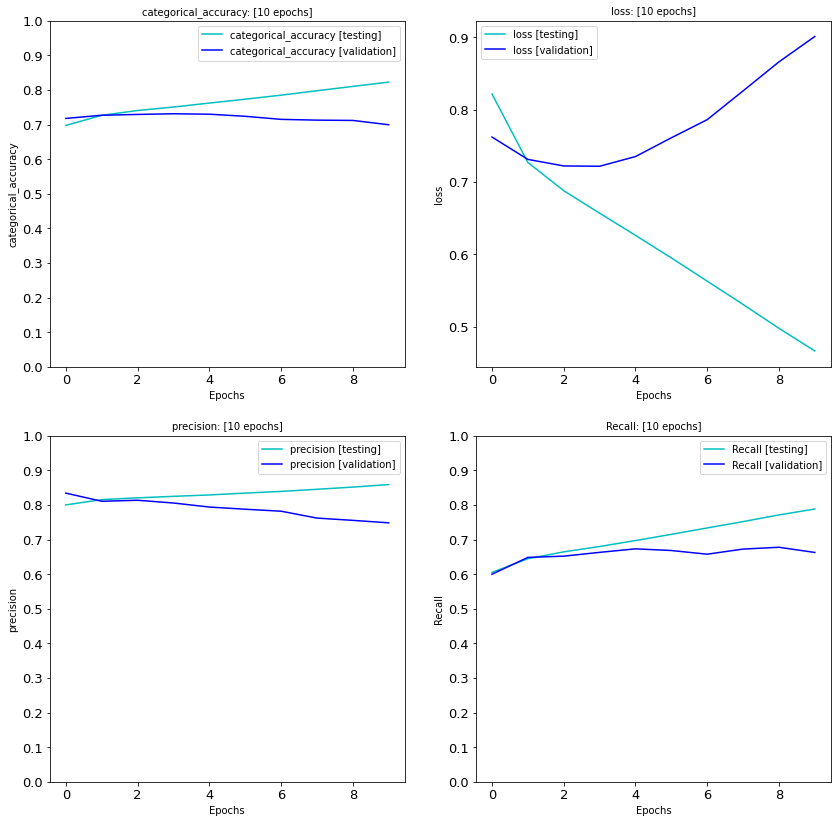

In [ ]:
nrows, ncols = 2, 2
fontsize = 10

# Flexible plotting size
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*nrows, 7*ncols))

# Set ticks
yticks = np.arange(0, 1.1, 0.1) # 0 to 1 in 0.1 increments
xticks = range(num_epochs)
xticks_labels = [str(i+1) for i in xticks] # For x axis labelling

def axis_plot(axis, metric):
    """
    TODO:
    """
    training = model_data.history[metric] # training data
    testing = model_data.history[f'val_{metric}'] # validation data

    # Plot training and validation
    axis.plot(training, 'c')
    axis.plot(testing, 'b')

    # Set labels
    axis.set_xlabel('Epochs', fontsize=fontsize)
    axis.set_ylabel(metric, fontsize=fontsize)
    # Don't cap yticks at 1 for loss since it can exceed 1.
    if metric != 'loss':
        axis.set_yticks(yticks)
    
    legend_text = f'{metric} [testing]', f'{metric} [validation]'
    axis.legend(legend_text)
    axis.tick_params(labelsize=13)
    axis.set_title(f'{metric}: [{num_epochs} epochs]', fontsize=fontsize)
    

# Reshape to iterate
metrics = [['categorical_accuracy', 'loss'], ['precision', 'Recall']]

# Plot
for i in range(len(metrics)):
    for j in range(len(metrics[0])):
        axis_plot(ax[i][j], metrics[i][j])

We can see that after just a single iteration, the loss for the validation data starts to rise. This is indicative of the possibility that we may be overfitting out model to our training data after just one epoch.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5f7cd34f-fff5-42b6-b8d8-aed6c2192391' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>